**Importing the Libraries**



In [1]:
import numpy as np
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam

**Defining the parameters(Image Size, Batch Size, Epochs)**

In [2]:
img_size = (128, 128)
batch_size= 32
epochs = 10

Path to dataset files: /kaggle/input/mask-detection


**Loading the Dataset**

In [ ]:
try:
  path = kagglehub.dataset_download("raaazzz/mask-detection")
  print(f"[INFO] Dataset downloaded to: {path}")
except Exception as e:
  print(f"[ERROR] Could not download dataset. Please check your Kaggle API credentials.")
  print(f"Error: {e}")
  return

**Splitting the Dataset**

In [3]:
datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        rotation_range=25,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest")
#Training Set
train_generator = datagen.flow_from_directory(
        DATASET_PATH,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="binary",
        subset="training",
        shuffle=True,
        seed=42)
#Validation Set
val_generator = datagen.flow_from_directory(
        DATASET_PATH,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="binary",
        subset="validation",
        shuffle=False,
        seed=42)
print("Train samples:", train_generator.samples)
print("Validation samples:", val_generator.samples)
print("Classes:", train_generator.class_indices)

**Distribution of Training Datasets and Validation Datasets**

In [ ]:
import numpy as np
# Training set distribution
train_labels = train_generator.classes
train_class_counts = np.bincount(train_labels)
print("Train class distribution:")
for class_name, count in zip(train_generator.class_indices.keys(), train_class_counts):
    print(f"  {class_name}: {count}")
# Validation set distribution
val_labels = val_generator.classes
val_class_counts = np.bincount(val_labels)
print("\nValidation class distribution:")
for class_name, count in zip(val_generator.class_indices.keys(), val_class_counts):
    print(f"  {class_name}: {count}")

**Creating the Model**

In [4]:
vgg= VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

for layer in vgg.layers:
        layer.trainable = False

head_model = vgg.output
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(1, activation="sigmoid")(head_model)
model = Model(inputs=vgg.input, outputs=head_model)

Found 15477 images belonging to 2 classes.
Found 3868 images belonging to 2 classes.
Train samples: 15477
Validation samples: 3868
Classes: {'with_mask': 0, 'without_mask': 1}


**Compiling the Model**

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

**Training the Model**

In [5]:
model_training= model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator)

Train class distribution:
  with_mask: 7687
  without_mask: 7790

Validation class distribution:
  with_mask: 1921
  without_mask: 1947


**Downloading the Model**

In [ ]:
from google.colab import files
files.download("mask_detection.keras")

**Classification Report of Model**

In [15]:
y_true = val_generator.classes
# Get predictions
y_pred_probablity = model.predict(val_generator)
y_pred = (y_pred_probablity > 0.5).astype("int32").flatten()
# Report
print(classification_report(y_true, y_pred, target_names=list(val_generator.class_indices.keys())))

121/121 ━━━━━━━━━━━━━━━━━━━━ 21s 177ms/step
              precision    recall  f1-score   support

   with_mask       0.99      0.78      0.87      1921
without_mask       0.82      0.99      0.90      1947

    accuracy                           0.88      3868
   macro avg       0.90      0.88      0.88      3868
weighted avg       0.90      0.88      0.88      3868



**Training Loss and Accuracy with Epochs**

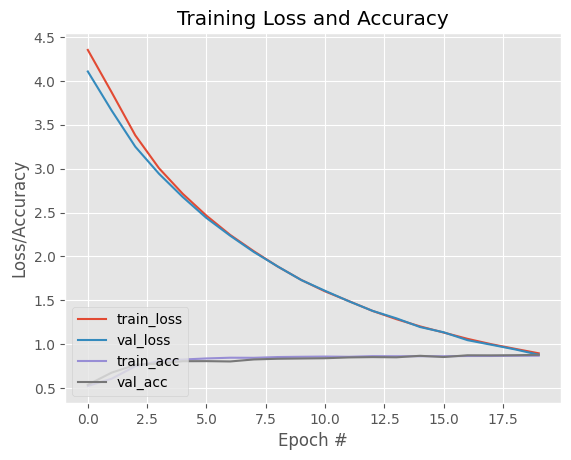

In [16]:
N = len(history.history["loss"])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch ")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

**Confusion Matrix and Heatmap**

121/121 ━━━━━━━━━━━━━━━━━━━━ 22s 178ms/step


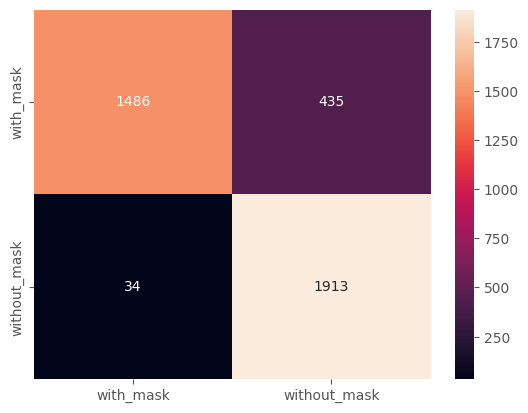

In [21]:
y_true = val_generator.classes
y_pred = (model.predict(val_generator) > 0.5).astype("int")
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=val_generator.class_indices.keys(),
            yticklabels=val_generator.class_indices.keys())
plt.show()